In [ ]:
# (a) Set up and solve with CVXPY the primal optimisation problem for a hardmargin support vector machine with this dataset using a linear kernel. Comment the results you get

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
X = pd.read_csv("svmdata.csv", header=None).values
y = pd.read_csv("svmlabel.csv", header=None).values.flatten()
n_samples, n_features = X.shape

# Define optimization variables
w = cp.Variable(n_features)
b = cp.Variable()

# Define the constraints for hard-margin SVM
constraints = [y[i] * (X[i] @ w + b) >= 1 for i in range(n_samples)]

# Define the objective function to minimize the norm of w
objective = cp.Minimize(0.5 * cp.sum_squares(w))

# Formulate and solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output the results
print("Solver Status:", problem.status)
if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print("Hard-margin SVM solution found.")
    print("Optimal weight vector (w):", w.value)
    print("Optimal bias (b):", b.value)

    # Visualize the data and decision boundary
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot data points for each class
    ax.scatter(X[y == 1, 0], X[y == 1, 1], X[y == 1, 2], c='blue', label='Class +1')
    ax.scatter(X[y == -1, 0], X[y == -1, 1], X[y == -1, 2], c='red', label='Class -1')

    # Create a grid to plot the decision boundary
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), 10),
        np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
    )

    # Calculate the corresponding z values for the decision boundary
    zz = (-w.value[0] * xx - w.value[1] * yy - b.value) / w.value[2]

    # Plot the decision boundary
    ax.plot_surface(xx, yy, zz, alpha=0.3, color='green')

    # Set labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()
    plt.title('Hard-Margin SVM Decision Boundary')
    plt.show()
else:
    print("Could not find a feasible solution. The data may not be linearly separable.")

Solver Status: infeasible
Could not find a feasible solution. The data may not be linearly separable.


In [9]:
# (b) Set up and solve with CVXPY the dual optimisation problem for a hardmargin support vector machine with this dataset using a linear kernel. Comment the results you get

In [27]:
import numpy as np
import pandas as pd
import cvxpy as cp

# Load dataset
X = pd.read_csv("svmdata.csv", header=None).values  # shape: (n_samples, 3)
y = pd.read_csv("svmlabel.csv", header=None).values.flatten()
y = np.where(y == 0, -1, y)  # convert 0 to -1

n = X.shape[0]
alpha = cp.Variable(n)

# Compute the Gram matrix using linear kernel
K = X @ X.T
H = np.outer(y, y) * K
H = 0.5 * (H + H.T)  # Symmetrize for numerical safety
H_psd = cp.psd_wrap(H)  # Tell CVXPY it's PSD

# Set up the dual problem
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, H_psd))
constraints = [alpha >= 0, cp.sum(cp.multiply(alpha, y)) == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS)

# Compute weight vector and bias if solved
if alpha.value is not None:
    alpha_val = alpha.value
    support_indices = np.where(alpha_val > 1e-5)[0]
    w = np.sum((alpha_val[support_indices] * y[support_indices])[:, None] * X[support_indices], axis=0)
    b = y[support_indices[0]] - np.dot(w, X[support_indices[0]])

    print("Weight vector w:", w)
    print("Bias b:", b)
    print("Support vectors at indices:", support_indices)
else:
    print("Problem status:", problem.status)
    print("Data may not be linearly separable (hard-margin SVM failed).")

Problem status: unbounded
Data may not be linearly separable (hard-margin SVM failed).


In [ ]:
# (c) Set up and solve with CVXPY the dual optimisation problem for a soft-margin
#support vector machine with this dataset using a linear kernel and regularisation parameter set to 1. Plot the data along with the decision hyperplane
#and margins for your support vector machine. Indicate the support vectors on your plot.


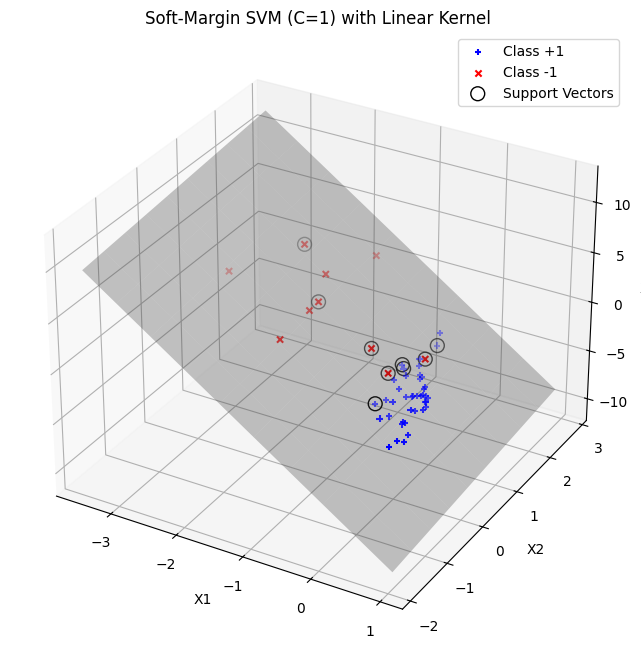

In [33]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
X = pd.read_csv("svmdata.csv", header=None).values
y = pd.read_csv("svmlabel.csv", header=None).values.flatten()
y = np.where(y == 0, -1, y)
n = X.shape[0]
C = 1  # Regularization parameter

# Define alpha variable
alpha = cp.Variable(n)

# Compute Gram matrix (linear kernel)
K = X @ X.T
H = np.outer(y, y) * K
H = 0.5 * (H + H.T)  # Symmetrize
H_psd = cp.psd_wrap(H)

# Dual objective and constraints
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, H_psd))
constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS)

# Get alpha values
alpha_val = alpha.value
support_indices = np.where(alpha_val > 1e-4)[0]

# Compute weight vector and bias
w = np.sum((alpha_val[support_indices] * y[support_indices])[:, None] * X[support_indices], axis=0)
b = y[support_indices[0]] - np.dot(w, X[support_indices[0]])

# Decision function
def decision_function(X):
    return X @ w + b

# ----------------------------------------
# Plotting in 3D with + and x markers
# ----------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot class +1 with '+', class -1 with 'x'
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], X[y == 1][:, 2], c='blue', marker='+', label='Class +1')
ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], X[y == -1][:, 2], c='red', marker='x', label='Class -1')

# Highlight support vectors with circles
ax.scatter(X[support_indices, 0], X[support_indices, 1], X[support_indices, 2],
           facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# Plot decision hyperplane
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 10),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 10))
zz = (-w[0]*xx - w[1]*yy - b) / w[2]
ax.plot_surface(xx, yy, zz, alpha=0.3, color='gray')

# Final plot adjustments
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
ax.set_title("Soft-Margin SVM (C=1) with Linear Kernel")
ax.legend()

plt.show()

Solves the dual of soft-margin SVM using CVXPY for C = 1.
Plots:
Positive and negative classes in red and blue.
The decision hyperplane.
Support vectors as circled points.
Works in 3D using Matplotlib’s Axes3D.